<a href="https://colab.research.google.com/github/neerajkumarvaid/Individual_Survival_Prediction/blob/main/SurvivalEVAL_for_Scikit_Survival_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
#!pip install pycox
#!pip install scikit-survival

In [48]:
import numpy as np
import matplotlib.pyplot as plt

from sksurv.datasets import load_gbsg2
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder
from sksurv.metrics import check_y_survival

from Evaluator import ScikitSurvivalEvaluator

In [49]:
%matplotlib inline

In [50]:
# load and prepare data
X, y = load_gbsg2()
X.loc[:, "tgrade"] = X.loc[:, "tgrade"].map(len).astype(int)
Xt = OneHotEncoder().fit_transform(X)

In [51]:
# Splitting the data into training/testing set. Training set contains 70% of the data. Testing set contains 30%.


n = len(Xt)

tr_size = int(n*0.70)

Xt_train, Xt_test = Xt.iloc[:tr_size, :], Xt.iloc[tr_size:, :]
y_train, y_test = y[:tr_size], y[tr_size:]
train_event_indicators, train_event_times = check_y_survival(y_train)
test_event_indicators, test_event_times = check_y_survival(y_test)

In [52]:
# Fit a CoxPH model.
est = CoxPHSurvivalAnalysis(ties="efron").fit(Xt_train, y_train)

In [53]:
# Retrieve individual survival functions and get probability of remaining event free from 1 year to 5 years (=1825 days).
survs = est.predict_survival_function(Xt_test)


In [54]:
# Build the evaluator. Training set information (durations_train and events_train) is optional if you don't need Brier score, integrated Brier score, and L1-margin loss.
eval = ScikitSurvivalEvaluator(survs, test_event_times, test_event_indicators, train_event_times, train_event_indicators)


In [55]:
# Calculate the concordance index. ties argument indicates the way ties should be handled. predicted_time_method argument indicates whether using median or mean survival time as the predicted time.
cindex, concordant_pairs, total_pairs = eval.concordance(ties="None", predicted_time_method="Median")
print("Concordance index is {}, meaning that the model can correctly order {} pairs among {} comparable pairs "
      "in the testing set.".format(cindex, concordant_pairs, total_pairs))

Concordance index is 0.6612887062831947, meaning that the model can correctly order 6599.0 pairs among 9979.0 comparable pairs in the testing set.


In [56]:
# Calculate the Brier score at time 175.

bs = eval.brier_score(target_time=175)
print("Brier score at time 175 is {}.".format(bs))

Brier score at time 175 is 0.009235037097327979.


In [58]:
# Calculate the l1-margin loss using mean survival times obtain from the survival curves as the predicted survival times. You can set method as 'Hinge' or 'Uncensored' for different l1 loss calculation.
l1 = eval.l1_loss(method='Margin', predicted_time_method="Median")
print("L1-margin loss is {}.".format(l1))

L1-margin loss is 995.1872169124991.


In [61]:
# L1 Hinge loss calculation
l1 = eval.l1_loss(method='Hinge', predicted_time_method="Median")
print("L1-Hinge loss is {}.".format(l1))

L1-Hinge loss is 518.9045746506413.


In [36]:
# Run one calibration test at 50-percentile-time among all the instances in testing set.

t_time = round(np.percentile(test_event_times, 50))
p_value, ob, pre = eval.one_calibration(target_time=t_time, method="DN")
if p_value >= 0.05:
    print("The model is one-calibrated at time {}.".format(t_time))
else:
    print("The model is not one-calibrated at time {}.".format(t_time))

The model is one-calibrated at time 858.


<Figure size 432x288 with 0 Axes>

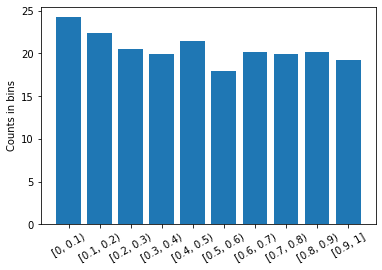

The model is d-calibrated!


In [37]:
# Run distribution calibration test.

p_value_2, bin_statistics = eval.d_calibration()
bins = ["[0, 0.1)", "[0.1, 0.2)", "[0.2, 0.3)", "[0.3, 0.4)", "[0.4, 0.5)", "[0.5, 0.6)", "[0.6, 0.7)", "[0.7, 0.8)",
        "[0.8, 0.9)", "[0.9, 1]"]
plt.clf()
fig, ax = plt.subplots()
ax.bar(bins, bin_statistics)
plt.setp(ax.get_xticklabels(), rotation=30)
plt.ylabel("Counts in bins")
plt.show()
if p_value_2 >= 0.05:
    print("The model is d-calibrated!")
else:
    print("The model is not d-calibrated!")